### `Tokenization and Embedding Extraction with BERT`

The text is cleaned and should be tokenized in a way that the embeddings can be extracted for later training.

First, let's install the pytorch interface for BERT by Hugging Face.

In [20]:
!pip install pytorch-pretrained-bert pytorch-nlp

In [38]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertModel, BertTokenizer
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm, trange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
df_tweets = pd.read_csv('preprocessed_tweets.csv')
df_tweets.shape

(22830, 9)

In [23]:
df_tweets = df_tweets.drop(['Unnamed: 0'], axis=1)
df_tweets.sample(10)

,vader_sentiment_label,vader_score,tweet,tweet_length,url_link,pos_emoji,neg_emoji,profanity_word
7430,0,-0.8625,skype therapi anxieti depress learn skype ther...,229,1,0,0,0
19158,0,-0.4215,die depress tell us gossip instead help,116,0,0,0,0
10819,0,-0.5719,depress impost syndrom v,48,0,0,0,0
6268,1,0.1280,love depress,17,0,0,0,0
7780,1,0.6737,love king shake gento go thing man wouldk whet...,278,0,0,0,0
22673,0,-0.2263,alien save wait gi lectur excessi depress nap,82,0,0,0,0
3095,0,-0.2960,therapist feel like call work th time week tak...,139,0,0,0,0
16398,0,-0.8225,cyber bulli main cau depress,44,1,0,0,0
16670,0,-0.5719,accumul depress doubl declin,40,0,0,0,0
8829,0,-0.8813,watch vi wouldeo felt therapeut like issu depr...,114,1,0,0,0


### Inputs
**BERT** requires specifically formatted inputs. For each tokenized input sentence, we need to create:

- **input ids**: a sequence of integers identifying each input token to its index number in the BERT tokenizer vocabulary
- **segment mask**: (optional) a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 1 for each token of the second sentence. Will not be used in this project.
- **attention mask**: (optional) a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens (we'll detail this in the next paragraph)
- **labels**: a single value of 1 or 0. In our task 1 means "grammatical" and 0 means "ungrammatical"

In [24]:
MAX_LEN = 128
PADDING = 'post'
TRUNCATING = 'post'
TRAINING_SPLIT = .75
DTYPE = 'long'
BATCH_SIZE = 32

### Tokenization

In [25]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Returns tokens of the tweet, and tensors of the tokens and segment ids
def tokenization(tweets, maxlen=MAX_LEN, dtype=DTYPE, truncating=TRUNCATING, padding=PADDING, tokenizer=tokenizer):
    tweets = ["[CLS] " + tweet + " [SEP]" for tweet in tweets]
    tokenized_texts = [tokenizer.tokenize(tweet) for tweet in tweets]

    # Map the token strings to their vocabulary indeces.
    input_ids = [tokenizer.convert_tokens_to_ids(text) for text in tokenized_texts]

    # Pad our input tokens
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype=dtype, truncating=truncating, padding=padding)

    # Create attention masks
    attention_masks = []

    for seq in input_ids:
      seq_mask = [float(i>0) for i in seq]
      attention_masks.append(seq_mask)

    # Convert inputs to PyTorch tensors
    # tokens_tensor = torch.tensor([indexed_tokens])
    # segments_tensor = torch.tensor([segments_ids])

    return tokenized_texts, input_ids, attention_masks

In [26]:
# Create tweets and labels lists
tweets = df_tweets.tweet.values
labels = df_tweets.vader_sentiment_label.values
tweets[0]

'wow dad yesterday take stupi would depress drug anymor though absolut worst thing never need great famili supporti mom sister stanc similar way'

In [27]:
tokenized_texts, input_ids, attention_masks = tokenization(tweets)
tokenized_texts[0], input_ids[0], attention_masks[0]

(['[CLS]',
  'wow',
  'dad',
  'yesterday',
  'take',
  'stu',
  '##pi',
  'would',
  'de',
  '##press',
  'drug',
  'any',
  '##mo',
  '##r',
  'though',
  'abs',
  '##ol',
  '##ut',
  'worst',
  'thing',
  'never',
  'need',
  'great',
  'fa',
  '##mi',
  '##li',
  'support',
  '##i',
  'mom',
  'sister',
  'stan',
  '##c',
  'similar',
  'way',
  '[SEP]'],
 array([  101, 10166,  3611,  7483,  2202, 24646,  8197,  2052,  2139,
        20110,  4319,  2151,  5302,  2099,  2295, 14689,  4747,  4904,
         5409,  2518,  2196,  2342,  2307,  6904,  4328,  3669,  2490,
         2072,  3566,  2905,  9761,  2278,  2714,  2126,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,

In [1]:
def train_val_split(input_ids, attention_masks, labels, training_split=TRAINING_SPLIT, batch_size=BATCH_SIZE):
    # Use train_test_split to split our data into train and validation sets for training
    train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                                                        random_state=2018, train_size=training_split)
    train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                                                                        random_state=2018, train_size=training_split)

    # Convert all of our data into torch tensors, the required datatype for our model
    train_inputs = torch.tensor(train_inputs)
    validation_inputs = torch.tensor(validation_inputs)

    train_labels = torch.tensor(train_labels)
    validation_labels = torch.tensor(validation_labels)

    train_masks = torch.tensor(train_masks)
    validation_masks = torch.tensor(validation_masks)

    # Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
    # with an iterator the entire dataset does not need to be loaded into memory
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
    validation_sampler = SequentialSampler(validation_data)
    validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

    return train_dataloader, validation_dataloader

NameError: name 'TRAINING_SPLIT' is not defined

In [29]:
train_dataloader, validation_dataloader = train_val_split(input_ids, attention_masks, labels)

### Loading and Fine-Tuning BERT
Now that our input data is properly formatted, it's time to fine tune the BERT model.

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.  

Because the pre-trained BERT layers already encode a lot of information about the language, training the classifier is relatively inexpensive. Rather than training every layer in a large model from scratch, it's as if we have already trained the bottom layers 95% of where they need to be, and only really need to train the top layer, with a bit of tweaking going on in the lower levels to accomodate our task.

In [30]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=Fa

In order for torch to use the GPU, we need to identify and specify the GPU as
the device. Later, in our training loop, we will load data onto the device.

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. At each pass we need to:

Training loop:
- Tell the model to compute gradients by setting the model in train mode
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

Evalution loop:
- Tell the model not to compute gradients by setting the model in evaluation mode
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress


In [32]:
LEARNING_RATE = 2e-5
EPOCHS = 4

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters, lr=LEARNING_RATE, warmup=.1)

In [33]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [34]:
def train_and_validation(train_dataloader, validation_dataloader, model, device, optimizer, epochs=EPOCHS):
    # Store our loss and accuracy for plotting
    train_loss_set = []

    for _ in trange(epochs, desc="Epoch"):

        # Training
        # set our model to training mode (as opposed to evaluation mode)
        model.train()

        # tracking variables
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0

        # train the data for one epoch
        for step, batch in enumerate(train_dataloader):
            # add batch to GPU
            batch = tuple(t.to(device) for t in batch)
            # unpack the inputs from dataloader
            b_input_ids, b_input_mask, b_labels = batch
            # clear out the gradients (by default they accumulate)
            optimizer.zero_grad()
            # forward pass
            loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            train_loss_set.append(loss.item())
            # backward pass
            loss.backward()
            # update parameters and take a step using the computed gradient
            optimizer.step()

            # update tracking variables
            tr_loss += loss.item()
            nb_tr_examples += b_input_ids.size(0)
            nb_tr_steps += 1

        print("Train loss: {}".format(tr_loss/nb_tr_steps))

        # Validation
        # put model on evaluation mode to evaluate loss on the validation set
        model.eval()

        # tracking variables
        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0

        # evaluate the data for one epoch
        for batch in validation_dataloader:
            # add batch to GPU
            batch = tuple(t.to(device) for t in batch)
            # unpack the inputs from dataloader
            b_input_ids, b_input_mask, b_labels = batch
            # telling the model not to compute or store gradients, saving memory and speed up validation
            with torch.no_grad():
                # forward pass, calculate logit predictions
                logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

            # move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            tmp_eval_accuracy = flat_accuracy(logits, label_ids)

            eval_accuracy += tmp_eval_accuracy
            nb_eval_steps += 1

        print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

    return train_loss_set

In [36]:
train_loss_set = train_and_validation(train_dataloader, validation_dataloader, model, device, optimizer)

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.29928882983026667


Epoch:  25%|██▌       | 1/4 [07:44<23:13, 464.63s/it]

Validation Accuracy: 0.8844855679702048
Train loss: 0.21621779141836425


Epoch:  50%|█████     | 2/4 [15:27<15:27, 463.85s/it]

Validation Accuracy: 0.884834729981378
Train loss: 0.13234936338397604


Epoch:  75%|███████▌  | 3/4 [23:11<07:43, 463.67s/it]

Validation Accuracy: 0.8763966480446927
Train loss: 0.07479473866466711


Epoch: 100%|██████████| 4/4 [30:54<00:00, 463.61s/it]

Validation Accuracy: 0.8711592178770949


## Training Evaluation

Let's take a look at our training loss over all batches:

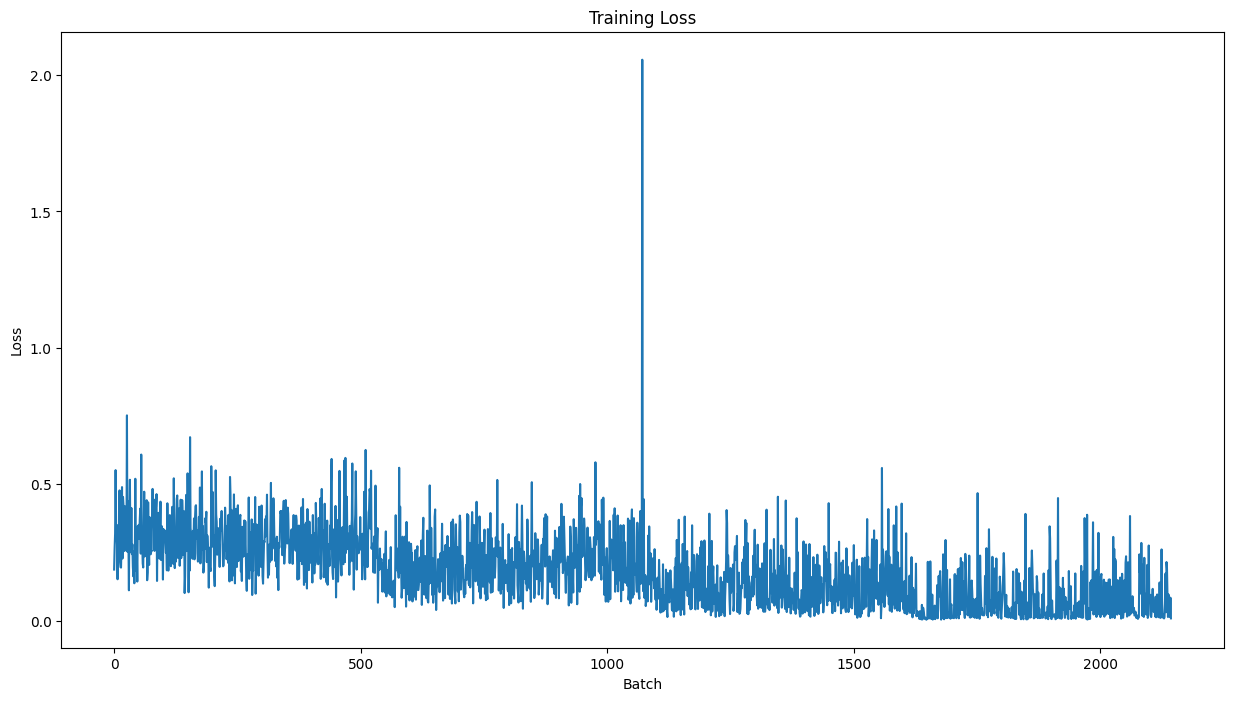

In [43]:
plt.figure(figsize=(15, 8))
plt.title('Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.plot(train_loss_set)
plt.show()

## Predict and Evaluate on Holdout Set
Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then, we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html).